Library imports - multiprocessing version, with filter

In [1]:
import datetime
from dateutil import parser
import pytz
from timezonefinder import TimezoneFinder

import numpy as np
import scipy.signal as signal
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt

import time, sys
import re

import xml.etree.ElementTree as ET
import bs4 as bs
import urllib.request
from selenium import webdriver

from multiprocessing import Pool, cpu_count

start_time = time.time()
    
#%matplotlib inline
#https://github.com/MrMinimal64/timezonefinder

utc=pytz.UTC

#debug = True
debug = True
filepath = './sample_data/'

if debug == False:
    gpx_file = input('Enter file name (must be in same directory as this program for now): ')
    tree = ET.parse(filepath + gpx_file)
else:
    tree = ET.parse('./sample_data/Exciter_100.gpx')
    #tree = ET.parse('./sample_data/ITPS_out.gpx')
    #tree = ET.parse('./sample_data/See_you_later_Winter_welcome_Spring.gpx')
root = tree.getroot()

each gps device has its own namespace for recording the GPX file... this function reads the embeded namespace

In [2]:
def namespace(element):
    m = re.match('\{(.*)\}', element.tag)
    return m.group(1) if m else ''

In [3]:
#url = 'http://vortex.plymouth.edu/cgi-bin/sfc/gen-statlog-a.cgi?ident=cyxu&pl=rawspec&yy=19&mm=04&dd=04&pg=web'
#dialog http://vortex.plymouth.edu/myo/sfc/statlog-a.html
#choose raw hourly & special METAR obs listings
#but only valid for us/cn/mx
#options
#http://www.ogimet.com/metars.phtml.en
#http://www.ogimet.com/display_metars2.php?lang=en&lugar=sbsp&tipo=ALL&ord=REV&nil=SI&fmt=html&ano=2019&mes=04&day=04&hora=00&anof=2019&mesf=04&dayf=04&horaf=23&minf=59&send=send

#https://www.cyclinganalytics.com/

In [4]:
#namespace = {'gpx':'http://www.topografix.com/GPX/1/1'}
namespace = {'gpx':namespace(root)}

In [5]:
#helper functions
def deg2rad(x):
    return x * np.pi / 180

def rad2deg(angle):
    return angle * 180 / np.pi

def kt2ms(speed):
    return speed * 0.5144444

def ms2kmh(speed):
    return speed * 3.6

def kmh2kt(speed):
    return speed / 1.852

This function calculates the distance and angle between 2 coordinates

In [6]:
def get_dist_trk(p2, p1):
    #p1 is a list with lat and long in degrees
    #p2 is also a list: lat long
    #returns distance and angle
    #distance in metres
    #reference: https://www.movable-type.co.uk/scripts/latlong.html
    R = 6371e3 #mean radius of Earth in meters
    phi1 = deg2rad(p1[0])
    phi2 = deg2rad(p2[0])
    lambda1 = deg2rad(p1[1])
    lambda2 = deg2rad(p2[1])
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    a = np.sin(delta_phi / 2) * np.sin(delta_phi / 2) + \
        np.cos(phi1) * np.cos(phi2) * \
        np.sin(delta_lambda / 2) * np.sin(delta_lambda / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    y = np.sin(delta_lambda) * np.cos(phi2)
    x = np.cos(phi1) * np.sin(phi2) - \
        np.sin(phi1) * np.cos(phi2) * np.cos(delta_lambda)
    brg = np.arctan2(y,x) * 180 / np.pi
    return d, brg + 180

Loop through GPX file for each recorded track point and calculate distance and angle

In [7]:
def get_trk_pts_data(trksegmt):
    '''
    function to generate track data
    input: list of tracksegments
    
    output: dataframe containing track data
    '''
    trackpoint = {}
    track = pd.DataFrame(columns=['lat', 'lon', 'elev', 'ts', 'dist', 'true_hdg', 'gs', 'delta_t', 'delta_elev'])
    first_point = True
    debug_counter = 0
    for idx, trkpoint in enumerate(trksegmt):
        trackpoint['lat'] = float(trkpoint.get('lat'))
        trackpoint['lon'] = float(trkpoint.get('lon'))
        for elev in trkpoint.findall('gpx:ele', namespace):
            #print(elev.text)
            trackpoint['elev'] = float(elev.text)
        for ts in trkpoint.findall('gpx:time', namespace):
            #print(ts.text)
            trackpoint['ts'] = parser.parse(ts.text)
        if first_point:
            previous_point = trackpoint
            first_point = False
        dist, angle = get_dist_trk([previous_point['lat'],previous_point['lon']], [trackpoint['lat'],trackpoint['lon']])
        if debug_counter < 20:
            #print(dist, trackpoint['lon'], previous_point['lon'])
            debug_counter += 1

        trackpoint['delta_t'] = (trackpoint['ts']-previous_point['ts']).total_seconds()
        trackpoint['dist'] = dist
        trackpoint['true_hdg'] = angle
        if trackpoint['delta_t'] != 0:
            trackpoint['gs'] = dist / trackpoint['delta_t']
        else:
            trackpoint['gs'] = 0
            trackpoint['delta_t'] = np.nan
        trackpoint['delta_elev'] = (trackpoint['elev']-previous_point['elev'])
        previous_point = trackpoint
        track = track.append(trackpoint, ignore_index=True)
        trackpoint = {}
    return track

In [8]:
print('Building track database...')
track = pd.DataFrame(columns=['lat', 'lon', 'elev', 'ts', 'dist', 'true_hdg', 'gs', 'delta_t', 'delta_elev'])
#lat in deg decimal
#lon in deg decimal
#elev in meters
#ts in datetime, tz=0
#dist in meters
#true_hdg in degrees
#gs in m/s

debug_counter = 0
n_proc = cpu_count() #number of multiprocesses in pool

for trk in root.findall('gpx:trk', namespace):
    for trksegmt in trk.findall('gpx:trkseg', namespace):
        first_point = True
        trkpoints = trksegmt.findall('gpx:trkpt', namespace)
        trk_pts_number = len(trkpoints)
        trk_pts_set = []
        
        for i in range(n_proc):
            if i < (n_proc - 1):
                trk_pts_set.append(trkpoints[int(trk_pts_number / n_proc) * (i):(int(trk_pts_number / n_proc) * (i+1) -1)])
            else:
                trk_pts_set.append(trkpoints[int(trk_pts_number / n_proc) * (i):trk_pts_number])
            
        #get_trk_pts_data(trk_pts_set[0])
        n_proc
        pool = Pool(n_proc)
        #map guarantees the order back
        results = pool.map(get_trk_pts_data, trk_pts_set)
        pool.join
        #join results:
        track = pd.DataFrame(columns=['lat', 'lon', 'elev', 'ts', 'dist', 'true_hdg', 'gs', 'delta_t', 'delta_elev'])
        for result in results:
            track = track.append(result.set_index('ts'))
        track['ts'] = track.index
        track.reset_index(inplace=True, drop=True)       
        pool.terminate
        pool.close()

end_time = time.time()
print()
print('Track build time was {:1.1f} seconds'.format(end_time - start_time))

Building track database...

Track build time was 116.9 seconds


In [50]:
def apply_filter(raw_data, N, Wn):
    
    # N is the filter order
    #Wn is the 3db cutoff kink point
    B, A = signal.butter(N, Wn, output='ba')
    
    filtered_data = signal.filtfilt(B, A, raw_data)
    return filtered_data

In [10]:
#pandas
#shift
#apply
#applymap
#run apply on column and use lambda to filter the 2 data points and pass to function

Calculate the mean LAT / LON

Find weather stations near the mean

In [11]:
radial_distance = 20 #nm
print(f'Figuring out nearest weather station...using {radial_distance} nm search radius...')
#nearest airport
#http://aviationweather.gov/adds/dataserver_current/httpparam?dataSource=stations&requestType=retrieve&format=xml&radialDistance=20;-81.275376,43.024538
lon_mean = track['lon'].mean()
lat_mean = track['lat'].mean()
ride_day = track['ts'][0].day
ride_month = track['ts'][0].month
ride_year = track['ts'][0].year



url = 'http://aviationweather.gov/adds/dataserver_current/httpparam?dataSource=stations&requestType=retrieve' + \
      '&format=xml&radialDistance=' + str(radial_distance) + ';' + str(lon_mean) + ',' + str(lat_mean)

source = urllib.request.urlopen(url).read()
tree = ET.ElementTree(ET.fromstring(source))
root = tree.getroot()
station_id_list = []
for data in root.findall('data'):
    for station in data.findall('Station'):
        for station_ident in station.findall('station_id'):
            station_id_list.append(station_ident.text)
print('Nearest stations are: ', station_id_list)

Figuring out nearest weather station...using 20 nm search radius...
Nearest stations are:  ['CWSN', 'CWSO', 'CYXU']


Cycle each station and try to find a METAR

If found, then create the weather database

If not found, asks user to enter prevailing wind speed and direction (true magnetic)

In [12]:
def get_ogi_data(station, ride_day, ride_month, ride_year):
    '''
    retrieve weather data from OGIMET
    this site only offers the last 30 days
    inputs:
        station: (str) - 4 letter code
        ride_day, ride_month, ride_year: (int)
    returns:
        found_data: (bool) true if data was found
        metinfo: (list) - parsed data
        
    site url template:
    http://www.ogimet.com/display_metars2.php?lang=en&amp;lugar=CYXU&amp;tipo=ALL&amp;ord=REV&amp;nil=SI&amp;fmt=html&amp;ano=2020&amp;mes=5&amp;day=16&amp;hora=00&amp;anof=2020&amp;mesf=5&amp;dayf=16&amp;horaf=23&amp;minf=59&amp;send=send
    http://www.ogimet.com/display_metars2.php?lang=en&lugar=CYXU&tipo=ALL&ord=REV&nil=SI&fmt=html&ano=2020&mes=05&day=16&hora=21&anof=2020&mesf=05&dayf=16&horaf=21&minf=59&send=send
    '''

    #only try to retrieve data if station is not null
    metar_found = False
    metar_db = []
    if station != '':
        url = 'http://www.ogimet.com/display_metars2.php?lang=en&lugar='+str(station)+ \
        '&tipo=ALL&ord=REV&nil=SI&fmt=html&ano='+str(ride_year)+ \
        '&mes='+str(ride_month)+'&day='+str(ride_day)+ \
        '&hora=00&anof='+str(ride_year)+'&mesf='+str(ride_month)+'&dayf='+str(ride_day)+ \
        '&horaf=23&minf=59&send=send'
        source = urllib.request.urlopen(url).read()
        soup = bs.BeautifulSoup(source, features='html.parser')
        table = soup.table
        table_rows = table.find_all('tr')
        metar_list = []
        for tr in table_rows:
            td = tr.find_all('td')
            row = [i.text for i in td]
            metar_list.append(row)
        for idx, line in enumerate(metar_list):
            #print(idx, line)
            for item in line:
                found = item.find('METAR '+str(station))
                if found != -1:
                    metar_found = True
                    try:
                        mday = int(item[found+11:found+13])
                        mhour = int(item[found+13:found+15])
                        mminute = int(item[found+15:found+17])
                        wind_dir = int(item[found+19:found+22])
                        wind_spd = int(item[found+22:found+24])
                        metar_station = str(station)
                        #print('mday:', mday)
                        #print('mhour:', mhour)
                        #print('mminute:', mminute)
                        #print('wind_dir:', wind_dir)
                        #print('wind_spd:', wind_spd)

                        metar_db.append([datetime.datetime(year=ride_year, month=ride_month, day=ride_day, 
                                                           hour=mhour, minute=mminute, second=0, tzinfo=pytz.UTC), 
                                                           wind_dir, wind_spd])
                        #wind speed is in knots, default of a METAR

                    except:
                        #print('parsing error')
                        pass
        #naming columns to harmonize with wunder...not my choice
        weather_data = pd.DataFrame(columns=['Time', 'Wind_Dir', 'Wind Speed'] , data=metar_db)
        weather_data['Time'] = pd.to_datetime(weather_data['Time'])
        weather_data.set_index('Time')
        return metar_found, weather_data
    else:
        return False, None

In [13]:
def get_wunder_data(station, ride_day, ride_month, ride_year):
    '''
    retrieve weather data from WUNDERGROUND
    inputs:
        station: (str) - 4 letter code
        ride_day, ride_month, ride_year: (int)
    returns:
        found_data: (bool) true if data was found
        metinfo: (pandas.df) - parsed data
        
    site url template:
      https://www.wunderground.com/history/daily/CYXU/date/2004-5-10
    '''
    
    url = 'https://www.wunderground.com/history/daily/'+str(station)+ \
    '/date/' + str(ride_year) + '-' + str(ride_month) + '-'+str(ride_day)

    # instantiate webdriver and get data
    # you need firefox bynary and the geckodriver installed
    # the geckodriver interfaces with firefox to get the page and pass the data back
    wd = webdriver.Firefox()
    wd.get(url)

    soup = bs.BeautifulSoup(wd.page_source, 'lxml')

    wd.quit()
    
    #find all tables
    
    data_found = False
    table_index = 0
    tables = soup.find_all('table')
    
    #find the correct table
    for tidx, table in enumerate(tables):
        table_head = table.findAll('th')
        output_head = []
        for head in table_head:
            output_head.append(head.text.strip())
            if output_head[0] == 'Time':
                data_found = True
                table_index = tidx
    #get the data
    
    if not data_found:
        #if no tables found, return false and an None
        return data_found, None
    else:

        table = tables[table_index]

        # parse table - first the header
        table_head = table.findAll('th')
        output_head = []
        for head in table_head:
            output_head.append(head.text.strip())

        # create empty dataframe
        weather_data = pd.DataFrame(columns=output_head)

        # parse rows
        output_rows = []
        rows = table.findAll('tr')
        for row in rows:
            columns = row.findAll('td')
            clean_row = []
            for column in columns:
                clean_row.append(column.text.strip().replace(u'\xa0', '') #this is to remove unwanted characters
                                 .replace('mph', '') 
                                 .replace('F', '')
                                 .replace('in', ''))
            if len(clean_row) > 0: # discard row if it is empty
                output_rows.append(clean_row)

        # add it all to the dataframe
        weather_data = pd.DataFrame(columns=output_head, data=output_rows).apply(pd.to_numeric, errors='ignore')

        # substitute wind direction for numeric headings
        wind_dir_dict = {"N":0,"NNE":22.5,"NE":45,"ENE":67.5,
                         "E":90,"ESE":112.5, "SE":135, "SSE":157.5,
                         "S":180,"SSW":202.5,"SW":225,"WSW":247.5,
                         "W":270,"WNW":292.5,"NW":315,"NNW":337.5, 
                         "CALM":0, "VAR":0}

        weather_data['Wind_Dir'] = weather_data['Wind'].map(wind_dir_dict)

        #make time something useful
        weather_data['Time'] = pd.to_datetime(weather_data['Time'].apply(lambda x : str(ride_year)+
                                                                         '-'+str(ride_month)+
                                                                         '-'+str(ride_day)+
                                                                         ' '+x))
        #harmonize and keep wind speed in kts
        weather_data['Wind Speed'] = kmh2kt(weather_data['Wind Speed'])
        
        return data_found, weather_data

In [14]:
metinfo_found = False
datetime.date.today()
delta_days = (datetime.date.today() - (track['ts'][0].to_pydatetime()).date()).days

station_index = 0
while metinfo_found == False and station_index < len(station_id_list):

    if delta_days < 30:
        #try to get data from ogimet
        #if successful set metinfo_found = True
        print(f"Checking if I can find data for station {station_id_list[station_index]} at OGI...", end='')
        
        if station_id_list[station_index]!= '':
            metinfo_found, metinfo_db = get_ogi_data(station_id_list[station_index], ride_day, ride_month, ride_year)
        if metinfo_found:
            print("found data!")
        else:
            print("no")
        
    if not metinfo_found:
        #try to get data from wunder
        #if successful, set metinfo_found = True
        print(f"Checking if I can find data for station {station_id_list[station_index]} at Wunder...", end='')
        
        if station_id_list[station_index]!= '':
            metinfo_found, metinfo_db = get_wunder_data(station_id_list[station_index], ride_day, ride_month, ride_year)
        if metinfo_found:
            #we neeed to shift the time because Wunder returns local time. We need UTC
            tf = TimezoneFinder()
            ride_tz = tf.timezone_at(lng=lon_mean, lat=lat_mean)
            metinfo_db['Time'] = pd.to_datetime(metinfo_db['Time']).dt.tz_localize(ride_tz).dt.tz_convert('UTC')
            
            print("found data!")
        else:
            print("no")
            
    station_index += 1
if not metinfo_found:
    #manual entry
    print('no auto METAR data')
    wind_dir = input('Enter wind direction (true heading): ')
    wind_spd = input('Enter wind speed: ')
    metinfo_db = pd.DataFrame(columns=['Time', 'Wind_Dir', 'Wind Speed'], data=[datetime.datetime(year=ride_year, month=ride_month, day=ride_day, 
                                                                                      hour=0, minute=0, second=0, tzinfo=pytz.UTC)])

Checking if I can find data for station CWSN at OGI...no
Checking if I can find data for station CWSN at Wunder...no
Checking if I can find data for station CWSO at OGI...no
Checking if I can find data for station CWSO at Wunder...no
Checking if I can find data for station CYXU at OGI...found data!


Calculates the headwind component and stores in database

Populate wind components...


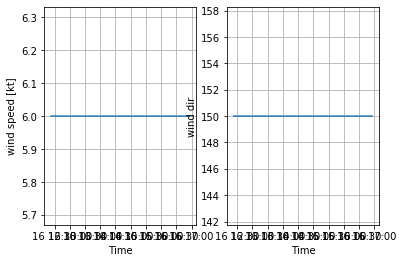

In [15]:
print('Populate wind components...')
#create columns
track['wind_spd'] = 0
track['wind_dir'] = 0

#find start
index_start = metinfo_db[track['ts'].iloc[0] <= metinfo_db['Time']].index[0]
index_end = metinfo_db[track['ts'].iloc[-1] < metinfo_db['Time']].index[0]

#find and set values
metinfo_indexes = range(index_start, index_end)
for metinfo_index in range(index_start, index_end+1):
    if metinfo_index == index_start:
        track.loc[track['ts'] <= metinfo_db['Time'].iloc[metinfo_index], ['wind_spd']] = metinfo_db['Wind Speed'].iloc[metinfo_index]
        track.loc[track['ts'] <= metinfo_db['Time'].iloc[metinfo_index], ['wind_dir']] = metinfo_db['Wind_Dir'].iloc[metinfo_index]

    elif metinfo_index < index_end:
        track.loc[(track['ts'] <= metinfo_db['Time'].iloc[metinfo_index]) & \
                   (track['ts'] > metinfo_db['Time'].iloc[metinfo_index - 1]), ['wind_spd']] = metinfo_db['Wind Speed'].iloc[metinfo_index]
        track.loc[(track['ts'] <= metinfo_db['Time'].iloc[metinfo_index]) & \
                   (track['ts'] > metinfo_db['Time'].iloc[metinfo_index - 1]), ['wind_dir']] = metinfo_db['Wind_Dir'].iloc[metinfo_index]

    else:
        track.loc[track['ts'] > metinfo_db['Time'].iloc[metinfo_index], ['wind_spd']] = metinfo_db['Wind Speed'].iloc[metinfo_index]
        track.loc[track['ts'] > metinfo_db['Time'].iloc[metinfo_index], ['wind_dir']] = metinfo_db['Wind_Dir'].iloc[metinfo_index]

fig, ax = plt.subplots(1,2)
ax[0].plot((track['ts']), track['wind_spd'])

ax[0].set(xlabel='Time', ylabel='wind speed [kt]')
ax[0].grid()

ax[1].plot((track['ts']), track['wind_dir'])

ax[1].set(xlabel='Time', ylabel='wind dir')
ax[1].grid()

#fig.savefig("test.png")
plt.show()

In [16]:
print('Calculating head winds...')

#delta_ang in degrees
#wind_component in m/s
track['delta_ang'] = track['true_hdg'] - track['wind_dir']
track['headwind_comp'] = np.cos(deg2rad(track['delta_ang'])) * kt2ms(track['wind_spd'])
track['airspeed'] = track['gs'] + track['headwind_comp'] #this in ms


Calculating head winds...


Calculates DRAG the power

Todo: interface for Cd and Area; Vary rho per altitude

In [17]:
print('Calculating power...')
rho = 1.225 #fixed for now kg/m3
Cd = 0.9 #fixed for me
S = 0.516 #measure from photo m2
track['filt_airspeed'] = apply_filter(track['airspeed'], 2, 0.08)
track['drag'] = 0.5 * rho * track['airspeed']**2 * Cd * S
track['drag_work'] = track['drag'] * track['dist'] #J

Calculating power...


Calculates the potential energy work

Todo: interface for cyclist and bike mass

In [51]:
cyclist_mass = 80 #kg
bike_mass = 10 #kg

mass = cyclist_mass + bike_mass #kg
g = 9.8 #m/s2
track['filt_delta_elev'] = apply_filter(track['delta_elev'], 2, 0.04)
track['pot_work'] = mass * g * track['filt_delta_elev'] #J
track['total_work'] = track['drag_work'] + track['pot_work'] #J
track['power'] = track['total_work'] / (track['delta_t'].values)
track.fillna(value=0, inplace=True)

In [19]:
print(track.describe())

                lat           lon          elev          dist      true_hdg  \
count  14447.000000  14447.000000  14447.000000  14447.000000  14447.000000   
mean      43.181700    -81.380250    283.496456      7.321956    230.122663   
std        0.108104      0.060567     12.105187      2.149605    100.349280   
min       43.026340    -81.489174    251.300000      0.000000      0.380501   
25%       43.075837    -81.416793    276.800000      6.582151    160.762625   
50%       43.165850    -81.393499    280.100000      7.477943    180.000000   
75%       43.286644    -81.343412    292.500000      8.196124    341.652218   
max       43.364515    -81.256297    307.000000     29.326055    360.000000   

            delta_t    delta_elev  wind_spd  wind_dir     delta_ang  \
count  14445.000000  14447.000000   14447.0   14447.0  14447.000000   
mean       1.130980     -0.000007       6.0     150.0     80.122663   
std        8.297059      0.236832       0.0       0.0    100.349280   
min 

Calculate averages and basic comparisons...

In [20]:
total_work = track['total_work'].sum()
pos_power_filter = track['total_work'] >= 0
print(f'Total work was {total_work:1.0f} Joules = {total_work * 0.000239006:1.0f} kcal')
workout_time = track['ts'].iloc[-1]-track['ts'].iloc[0]
print('Workout time was {}, or {:1.0f} seconds'.format(workout_time, workout_time.total_seconds()))
print('Average overall power was {:1.0f} Watts'.format(total_work / workout_time.total_seconds()))
print('Average positive power was {:1.0f} Watts'.format(track[track['total_work'] >= 0]['total_work'].sum() / workout_time.total_seconds()))

Total work was 2155404 Joules = 515 kcal
Workout time was 0 days 04:32:19, or 16339 seconds
Average overall power was 132 Watts
Average positive power was 145 Watts


In [21]:
end_time = time.time()
print('execution time was {:0.1f} seconds'.format(end_time - start_time))

execution time was 312.1 seconds


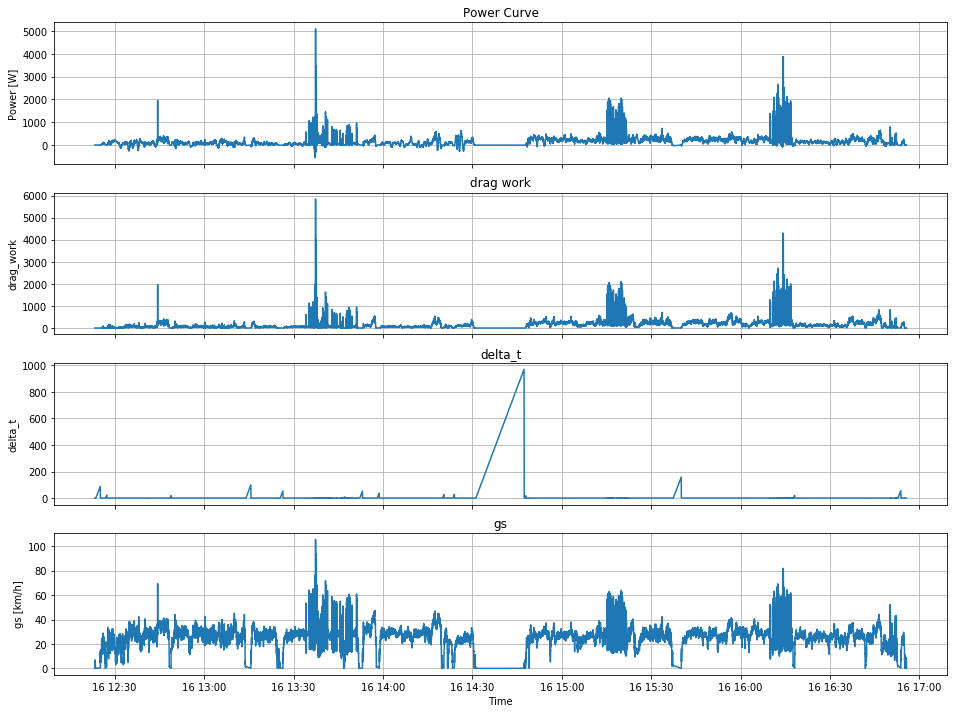

In [61]:
plt.rcParams['figure.figsize'] = [16, 12]
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot((track['ts']),track['power'])

axarr[0].set(ylabel='Power [W]',
       title='Power Curve')
axarr[0].grid()

axarr[1].plot((track['ts']),track['drag_work'])

axarr[1].set(ylabel='drag_work',
       title='drag work')
axarr[1].grid()

axarr[2].plot((track['ts']),track['delta_t'].values)

axarr[2].set(ylabel='delta_t',
       title='delta_t')
axarr[2].grid()

axarr[3].plot((track['ts']),(track['gs'])*3.6)

axarr[3].set(xlabel='Time', ylabel='gs [km/h]',
       title='gs')
axarr[3].grid()
             

#fig.savefig("test.png")
plt.show()


In [ ]:
fig, ax = plt.subplots()
ax.plot((track['ts']),track['pot_work'])

ax.set(xlabel='Time', ylabel='energy [J]',
       title='Geopotential Work Curve')
ax.grid()

#fig.savefig("test.png")
plt.show()

In [ ]:
'''
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot((track['ts']),track['power'], alpha=0.8, linewidth=0.3)

axarr[0].set(xlabel='Time', ylabel='Power [W]',
       title='Power Curve')
axarr[0].set_ylim([0, track['power'].max()])
axarr[0].grid()

axarr[1].plot((track['ts']),track['elev'])

axarr[1].set(xlabel='Time', ylabel='Elevation [m]',
       title='Elevation Curve')
axarr[1].grid()

axarr[2].plot((track['ts']),track['delta_ang'])

axarr[2].set(xlabel='Time', ylabel='delta [deg]',
       title='Wind Relative Angle Curve')
axarr[2].grid()

axarr[3].plot((track['ts']),track['delta_elev'])

axarr[3].set(xlabel='Time', ylabel='[m]',
       title='Delta Elev')
axarr[3].grid()
             

#fig.savefig("test.png")
plt.show()
'''

In [ ]:
f, axarr = plt.subplots(4, sharex=True)

color = 'tab:green'
axarr[0].fill_between((track['ts']),track['elev'].min(),track['elev'], color=color, alpha=0.3)
axarr[0].set_ylabel('Elevation [m]', color=color)
#fill_between(x, 0, y1)

color = 'tab:red'
ax2 = axarr[0].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot((track['ts']),track['power'], alpha=0.8, linewidth=0.3, color=color)

ax2.set(xlabel='Time', title='Power and Elevation Curves')
ax2.set_ylabel('Power [W]', color=color)
ax2.set_ylim([0, track['power'].max()])
ax2.grid()

color = 'tab:red'
axarr[1].plot((track['ts']),track['drag'], alpha=0.8, linewidth=0.3, color=color)


axarr[1].set(title='Drag Curve')
axarr[1].set_ylabel(ylabel='Drag [N]', color=color)
axarr[1].grid()

color = 'tab:blue'
gs_kmh = ms2kmh(track['gs'])
ax3 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
ax3.plot((track['ts']), gs_kmh, color=color, linewidth=0.3)
ax3.set_ylabel('Ground Speed [km/h]', color=color)

axarr[2].plot((track['ts']),ms2kmh(track['headwind_comp']))

axarr[2].set(ylabel='head wind [km/h]',
       title='Head Wind Curve')
axarr[2].grid()

axarr[3].plot((track['ts']),track['delta_elev'])

axarr[3].set(xlabel='Time', ylabel='[m]',
       title='Delta Elev')
axarr[3].grid()
             

#fig.savefig("test.png")
plt.show()

Power Histogram

In [ ]:
track[track['total_work'] >= 0]
ax = track[track['power']>=0]['power'].plot.hist(bins=30, alpha=0.5)

Power Bins/Time

Let's plot now how many minutes was spent in each power bin.

Change the power range and bin size below.

In [ ]:
min_power = 0
max_power = 1000
power_bin_width = 50


power_bins =  range(min_power, max_power, power_bin_width)
track['power_bin'] = pd.cut(track['power'], power_bins)
((track.groupby(['power_bin']).sum().loc[:,'delta_t'])/60).plot(kind='bar', title='Time [m] spent in power [W]');

In [ ]:
track.head(15)

In [ ]:
cpu_count()